Hi Avinash,
Sorry for the delayed response. We're just getting to this task in case you're still interested as quick summary of the problem. We have an python script which converts an stl file into a 2d depth image. It does this by largely acting as a slicer and finding the highest occupied slice for each x,y point.

There are however two main problems:
- it's not working on one file in particular.
- it needs to have the dimensions of the output file input manually. If this isn't done right (putting in square width and length dimensions for a non-square object then it'll end up skewed).

We're looking for someone to find out why it's not working with the tactile display.stl file and then add some code so that it automatically scales to the right size so that the aspect ratio of the model are the same in the output image and the model.

As a bonus it'd be good to be able to slice the model from different directions(90 degrees increments) and get a preview of these (sometimes we need to rotate the model before slicing it). This isn't essential though the main tasks are the first two.

attached is the current python slicing code, some example stl files which have been converted correctly and the tactile_display file which has been converted incorrectly.

In [85]:
# Define the 8 vertices of the cube
# vertices = np.array([\
#     [-1, -1, -1],
#     [+1, -1, -1],
#     [+1, +1, -1],
#     [-1, +1, -1],
#     [-1, -1, +1],
#     [+1, -1, +1],
#     [+1, +1, +1],
#     [-1, +1, +1]])
# # Define the 12 triangles composing the cube
# faces = np.array([\
#     [0,3,1],
#     [1,3,2],
#     [0,4,7],
#     [0,7,3],
#     [4,5,6],
#     [4,6,7],
#     [5,1,2],
#     [5,2,6],
#     [2,3,6],
#     [3,7,6],
#     [0,1,5],
#     [0,5,4]])

# # Create the mesh
# cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
# for i, f in enumerate(faces):
#     for j in range(3):
#         cube.vectors[i][j] = vertices[f[j],:]

# # Write the mesh to file "cube.stl"
# cube.save('cube.stl')
# !stl2ascii cube.stl cube_ascii.stl

In [45]:
import cv2
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# New implementation

In [171]:
width = 200
path = "./not working/stl_files/"
# path = "./working/stl_files/"
# path = "./"
# file_name = "modified_cube"
# file_name = "Dolphin_cropped"
file_name = "tactile_display_1_basic"
# file_name = "crater"
file_ext = ".stl"
file_path = path + file_name + file_ext;
# Load the STL file
model = mesh.Mesh.from_file(file_path)

In [172]:
#Theta is in radians, and rotates in counter-clockwise direction, so use -ve theta for clockwise rotation
# Specify the axes of rotation as unit vector in [x,y,z]
model.rotate([1,0,0],theta=np.deg2rad(-90))

In [173]:
model.translate(np.array([-model.x.min(),-model.y.min(),-model.z.min()]))

In [174]:
def preview_model(model):
    # Create a new plot
    figure = pyplot.figure()
    axes = mplot3d.Axes3D(figure)
    collection = mplot3d.art3d.Poly3DCollection(model.vectors)
    collection.set_edgecolor((0,0,0))
    # Add the vectors to the plot
    axes.add_collection3d(collection)
    # Auto scale to the mesh size
    scale = model.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    # Show the plot to the screen
    pyplot.show()

In [175]:
height = (model.y.max() - model.y.min()) * width / (model.x.max() - model.x.min());
height = int(np.fabs(np.ceil(height)));

In [176]:
height

200

In [177]:
# Scale the model while maintaining aspect ratios or face normals according to the width of depth image
scale = width / model.x.max()
model.x = model.x * scale
model.y = model.y * scale
model.z = model.z * scale

In [178]:
model.y.max()

200.0

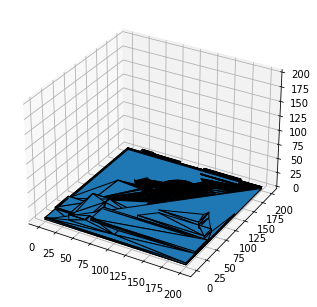

In [179]:
preview_model(model)

In [180]:
# Determine if the pixel is oriented with normal or not
def oriented(p,v0,v1,v2):
    n1 = np.cross(v2-v1, p-v1)
    n2 = np.cross(v2-v1, v0-v1)
    if np.dot(n1,n2) >= 0:
        return True
    else:
        return False

# Determine if a pixel is in the triangle or not
def pixel_in_triangle(p,v0,v1,v2):
    if oriented(p,v0,v1,v2) and oriented(p,v1,v0,v2) and oriented(p,v2,v0,v1):
        return True
    else:
        return False

# Calculate depth of valid x, y pixels locations
def calculate_depth(x,y,index):
    # Get the normals
    nx, ny, nz = model.normals[index]
    # Get any one vertex
    v0 = model.v0[index]
    v1 = model.v1[index]
    v2 = model.v2[index]
    
    # Calculate depth at (x,y) from equation of a plane in 3D
    depth = 0
    p = np.array([x,y])
    if pixel_in_triangle(p,v0[:2],v1[:2],v2[:2]):
        if nz != 0:
            depth = ((nx*(x-v0[0]) + ny*(y-v0[1]))/(-nz)) + v0[2]
    return depth

In [181]:
im = np.zeros((height+1, width+1))

In [182]:
for triangle_index in range(model.normals.shape[0]):
    for y in range(int(model.y[triangle_index].min()), int(model.y[triangle_index].max())+1):
        for x in range(int(model.x[triangle_index].min()), int(model.x[triangle_index].max())+1):
            depth = calculate_depth(x,y,triangle_index)
            if im[y,x] < depth:
                im[y,x] = depth

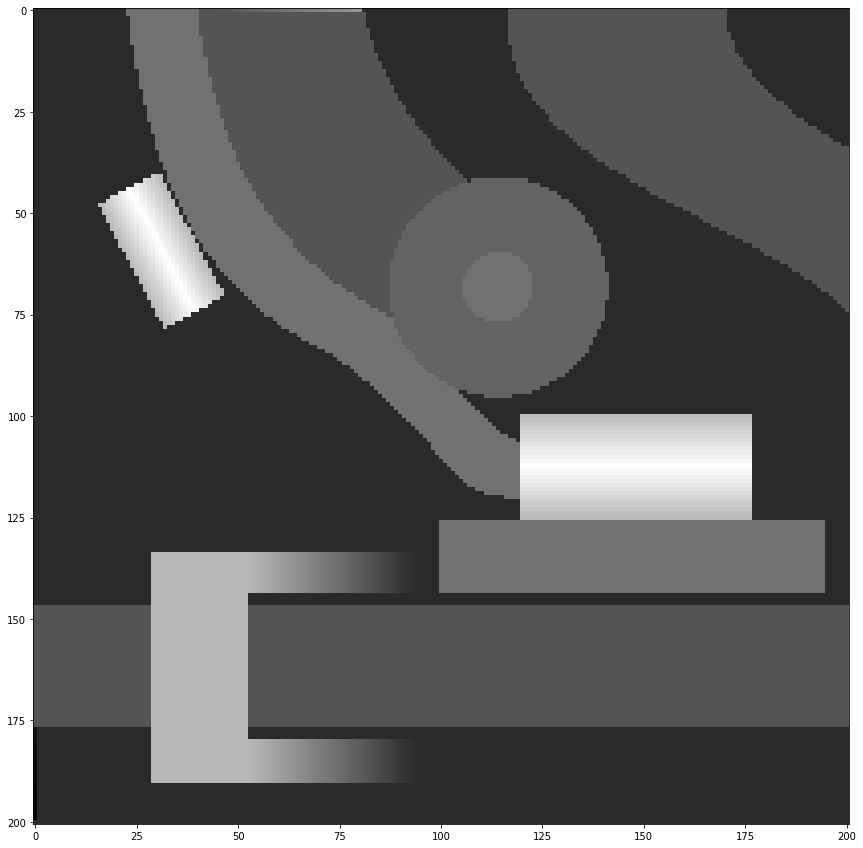

In [183]:
im = (im - im.min()) * 255 / (im.max() - im.min())
pyplot.figure(figsize=(15,15))
pyplot.imshow(im[::-1,:], cmap="gray")

In [170]:
"""# Visualise the final output"""

cv2.imshow("output", im[::-1,:].astype(np.uint8))
print("\n\nshape: ", im.shape)

cv2.waitKey(0)

save_path = str(file_name + "_rot90_x.png")
print("saving at this path: ", save_path)
cv2.imwrite(save_path, im[::-1,:].astype(np.uint8))



shape:  (201, 201)
saving at this path:  tactile_display_1_basic_rot90_x.png


True

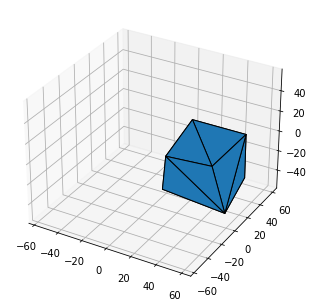

[[ 0.          4.          0.        ]
 [ 0.          4.          0.        ]
 [-0.57481027 -0.48828578  3.8791819 ]
 [ 0.          0.          4.708802  ]
 [-0.05768299 -4.1263785  -0.54696435]
 [-0.17858434 -3.999631   -0.6567012 ]
 [ 0.          0.         -4.        ]
 [-0.48828578  0.48828578 -4.6300464 ]
 [ 4.          0.63004637  0.        ]
 [ 5.2836127   0.          0.74169093]
 [-4.          0.          0.        ]
 [-3.9842489  -0.504037    0.504037  ]]


In [62]:
#Theta is in radians, and rotates in counter-clockwise direction
model.rotate([0,1,0],theta=-np.deg2rad(90))
preview_model(model)
print(model.normals)

# Old implementation

In [86]:
layers:int = 50
W,H,L = 500, 500, layers
# path = "working/stl_files/"
# path = "not working/stl_files/"
path = "./"
# file_nme="Dolphin_cropped"
# file_nme="tactile_display_1_basic"
file_nme="modified_cube"
model_ext = ".stl"
file_path = str(path+file_nme+model_ext)

your_mesh = mesh.Mesh.from_file(file_path)

In [89]:
def map_vals(cur_arr):
    """remap vals to range"""

    info = np.iinfo(cur_arr.dtype) # Get the information of the incoming image type
    data = cur_arr.astype(np.float64) / np.amax(cur_arr) # normalize the data to 0 - 1
    data = info.max * data # Now scale by 255
    img = data.astype(np.uint8)

    return img

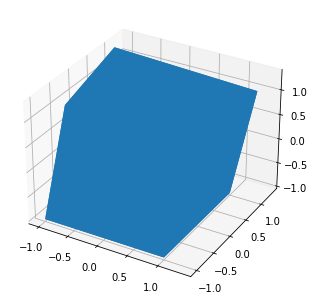

In [90]:
# Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten()

axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

In [92]:
print("flattened points shape: ", scale.shape)
print("mesh.shape: ", your_mesh.points.shape)
print("z mean: ", your_mesh.z.mean())
print("z.max: ", your_mesh.z.max())

flattened points shape:  (108,)
mesh.shape:  (12, 9)
z mean:  0.06562981
z.max:  1.354401


In [93]:
Z = (your_mesh.z - your_mesh.z.min())/(your_mesh.z.max() - your_mesh.z.min())*(L-1)
X = (your_mesh.x - your_mesh.x.min())/(your_mesh.x.max() - your_mesh.x.min())*(W-1)
Y = (your_mesh.y - your_mesh.y.min())/(your_mesh.y.max() - your_mesh.y.min())*(H-1)

In [94]:
print("X:", X.min(), X.max())
print("Y:", Y.min(), Y.max())
print("Z:", Z.min(),Z.max())
print("Shapes:", X.shape, Y.shape, Z.shape)

X: 0.0 499.0
Y: 0.0 499.0
Z: 0.0 49.0
Shapes: (12, 3) (12, 3) (12, 3)


In [95]:
your_points = np.dstack((your_mesh.x, your_mesh.y, your_mesh.z))

In [96]:
your_points

array([[[-1.       , -1.       , -1.       ],
        [-1.       ,  1.       , -1.       ],
        [ 1.       , -1.       , -1.       ]],

       [[ 1.       , -1.       , -1.       ],
        [-1.       ,  1.       , -1.       ],
        [ 1.       ,  1.       , -1.       ]],

       [[-1.       , -1.       , -1.       ],
        [-0.7558571, -0.7479815,  1.2362673],
        [-1.       ,  1.       ,  1.354401 ]],

       [[-1.       , -1.       , -1.       ],
        [-1.       ,  1.       ,  1.354401 ],
        [-1.       ,  1.       , -1.       ]],

       [[-0.7558571, -0.7479815,  1.2362673],
        [ 1.       , -1.       ,  1.       ],
        [ 1.2441429,  1.3150232,  1.       ]],

       [[-0.7558571, -0.7479815,  1.2362673],
        [ 1.2441429,  1.3150232,  1.       ],
        [-1.       ,  1.       ,  1.354401 ]],

       [[ 1.       , -1.       ,  1.       ],
        [ 1.       , -1.       , -1.       ],
        [ 1.       ,  1.       , -1.       ]],

       [[ 1.       ,

In [97]:
your_points.shape

(12, 3, 3)

In [111]:
your_points.max(axis=2)

array([[-1.       ,  1.       ,  1.       ],
       [ 1.       ,  1.       ,  1.       ],
       [-1.       ,  1.2362673,  1.354401 ],
       [-1.       ,  1.354401 ,  1.       ],
       [ 1.2362673,  1.       ,  1.3150232],
       [ 1.2362673,  1.3150232,  1.354401 ],
       [ 1.       ,  1.       ,  1.       ],
       [ 1.       ,  1.       ,  1.3150232],
       [ 1.       ,  1.       ,  1.3150232],
       [ 1.       ,  1.354401 ,  1.3150232],
       [-1.       ,  1.       ,  1.       ],
       [-1.       ,  1.       ,  1.2362673]], dtype=float32)

In [98]:
for x,y,z in zip(X,Y,Z):
    print(x,y,z)

[  0.       0.     444.7132] [  0.     431.0972   0.    ] [0. 0. 0.]
[444.7132   0.     444.7132] [  0.     431.0972 431.0972] [0. 0. 0.]
[ 0.      54.28678  0.     ] [  0.       54.32224 431.0972 ] [ 0.      46.54139 49.     ]
[0. 0. 0.] [  0.     431.0972 431.0972] [ 0. 49.  0.]
[ 54.28678 444.7132  499.     ] [ 54.32224   0.      499.     ] [46.54139  41.624172 41.624172]
[ 54.28678 499.        0.     ] [ 54.32224 499.      431.0972 ] [46.54139  41.624172 49.      ]
[444.7132 444.7132 444.7132] [  0.       0.     431.0972] [41.624172  0.        0.      ]
[444.7132 444.7132 499.    ] [  0.     431.0972 499.    ] [41.624172  0.       41.624172]
[444.7132   0.     499.    ] [431.0972 431.0972 499.    ] [ 0.        0.       41.624172]
[  0.   0. 499.] [431.0972 431.0972 499.    ] [ 0.       49.       41.624172]
[  0.     444.7132 444.7132] [0. 0. 0.] [ 0.        0.       41.624172]
[  0.      444.7132   54.28678] [ 0.       0.      54.32224] [ 0.       41.624172 46.54139 ]


In [99]:
Di = {}
for x,y,z in zip(X,Y,Z):
    layers = range(int(min(z)),int(max(z))+1)
    for l in layers:
        if l in Di:
            Di[l].append([x,y,z])
        else:
            Di[l] = [[x,y,z]]

In [100]:
range(int(min(z)),int(max(z))+1)

range(0, 47)

In [101]:
Di.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [102]:
Di[0]

[[array([  0.    ,   0.    , 444.7132], dtype=float32),
  array([  0.    , 431.0972,   0.    ], dtype=float32),
  array([0., 0., 0.], dtype=float32)],
 [array([444.7132,   0.    , 444.7132], dtype=float32),
  array([  0.    , 431.0972, 431.0972], dtype=float32),
  array([0., 0., 0.], dtype=float32)],
 [array([ 0.     , 54.28678,  0.     ], dtype=float32),
  array([  0.     ,  54.32224, 431.0972 ], dtype=float32),
  array([ 0.     , 46.54139, 49.     ], dtype=float32)],
 [array([0., 0., 0.], dtype=float32),
  array([  0.    , 431.0972, 431.0972], dtype=float32),
  array([ 0., 49.,  0.], dtype=float32)],
 [array([444.7132, 444.7132, 444.7132], dtype=float32),
  array([  0.    ,   0.    , 431.0972], dtype=float32),
  array([41.624172,  0.      ,  0.      ], dtype=float32)],
 [array([444.7132, 444.7132, 499.    ], dtype=float32),
  array([  0.    , 431.0972, 499.    ], dtype=float32),
  array([41.624172,  0.      , 41.624172], dtype=float32)],
 [array([444.7132,   0.    , 499.    ], dtype=

In [106]:
im_layers =[]
A,B = [],[]

for layer in range(L):
    im = np.ones((W, H, 3), np.uint8) * 0
    for xx,yy,zz in Di[layer]:
        z0,z1,z2 = sorted(zz)
        z0,z1,z2 = int(z0),int(z1),int(z2)
        x0,x1,x2 = sorted(xx)
        x0,x1,x2 = int(x0),int(x1),int(x2)
        y0,y1,y2 = sorted(yy)
        y0,y1,y2 = int(y0),int(y1),int(y2)
        # a,b = int(xx.mean()),int(yy.mean())

        for a in range(x0,x2+1):
            for b in range(y0,y2+1):
                im[a,b]=layer
    im_layers.append(im)

In [107]:
print("number of layers: ", len(im_layers))
arr_layers = np.asarray(im_layers)

print("arr_layers, type: ", type(arr_layers))

# The list of 2D arrays of layers
print("arr_layers shape: ", arr_layers.shape)

out = np.max(arr_layers,axis = 0)
print("out.shape: ", out.shape)


"""# Check the number of layers"""
print(len(set(out.reshape((W)*(H)*3).tolist())))

print(set(out.reshape((W)*(H)*3).tolist()))

"""# The final output"""

output = out[:,:,0]
print("output.shape: ", output.shape)

output = map_vals(output)

number of layers:  50
arr_layers, type:  <class 'numpy.ndarray'>
arr_layers shape:  (50, 500, 500, 3)
out.shape:  (500, 500, 3)
2
{49, 46}
output.shape:  (500, 500)


In [108]:
"""# Visualise the final output"""
cv2.imshow("output", output)
print("\n\nshape: ", output.shape)

cv2.waitKey(0)

save_path = str(file_nme + ".png")
print("saving at this path: ", save_path)
cv2.imwrite(save_path, output)



shape:  (500, 500)
saving at this path:  modified_cube.png


True